<a href="https://colab.research.google.com/github/Gabriel-Mourad/treball_final_INAM/blob/main/MyFit_IA_Pose_Estimator_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Gabriel-Mourad/human-pose-estimation-opencv.git
%cd human-pose-estimation-opencv/

Cloning into 'human-pose-estimation-opencv'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.
/content/human-pose-estimation-opencv


In [ ]:
%cd human-pose-estimation-opencv/
%ls

[Errno 2] No such file or directory: 'human-pose-estimation-opencv/'
/content/human-pose-estimation-opencv
dance.mp4     image1.jpg  image_prova.jpg  openpose.py  README.md
graph_opt.pb  image.jpg   LICENSE          output.JPG


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import cv2 as cv
import numpy as np
import os
import math
from google.colab.patches import cv2_imshow

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"], ["RKnee", "LKnee"], ["RAnkle", "LAnkle"]]


net = cv.dnn.readNetFromTensorflow("graph_opt.pb")


thr = 0.1
IN_WIDTH = 396
IN_HEIGHT = 368



# key angles: RightArm is the angle between Rshoulder, RElbow,RWrist
# note for some calcs we can reuse the same connects!

KEY_DISTANCES = {"RArm":{"RShoulder-RElbow":None,"RElbow-RWrist":None,"Neck-RShoulder":None},
                "LArm":{"LShoulder-LElbow":None,"LElbow-LWrist":None,"Neck-LShoulder":None},
                "RLeg":{"RHip-RKnee":None,"RKnee-RAnkle":None},
                "LLeg":{"LHip-RKnee":None,"LKnee-RAnkle":None},
                 "KNEE":{"RKnee-LKnee": None},
                 "Ankle":{"RAnkle-LAnkle": None}}

KEY_ANGLES = {"RArm": [],"LArm":[],"RLeg":[],"LLeg":[]}

TEXT_COLOR = (0,0,0)

def rad_to_deg(rad):
    return rad * (180/math.pi)

def pose_key_angles(frame):

    RShoulder_pos = None
    RWrist_pos = None

    LShoulder_pos = None
    LWrist_pos = None

    Neck_pos = None
    
    RElbow_pos = None
    LElbow_pos = None

    RHip_pos = None
    RKnee_pos = None
    RAnkle_pos = None

    LHip_pos = None
    LKnee_pos = None
    LAnkle_pos = None

    a1 = None
    a2 = None
    frame_h,frame_w = frame.shape[0:2]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (IN_WIDTH, IN_HEIGHT), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  

    assert(len(BODY_PARTS) == out.shape[1])

    POINTS = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frame_w * point[0]) / out.shape[3]
        y = (frame_h * point[1]) / out.shape[2]
        POINTS.append((int(x), int(y)) if conf > thr else None)

          
    
    
    for pair in POSE_PAIRS:

        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]



        if POINTS[idFrom] and POINTS[idTo]:


                if(partFrom == "RShoulder"):
                    RShoulder_pos = POINTS[idFrom]

                if(partTo == "RWrist"):
                    RWrist_pos = POINTS[idTo]

                if(partFrom == "LShoulder"):
                    LShoulder_pos = POINTS[idFrom]

                if(partTo == "LWrist"):
                    LWrist_pos = POINTS[idTo]

                if(partFrom == "Neck"):
                    Neck_pos = POINTS[idFrom]
                
                if(partTo == "RElbow"):
                    RElbow_pos = POINTS[idTo]

                if(partTo == "LElbow"):
                    LElbow_pos = POINTS[idTo]

                if(partFrom == "RHip"):
                    RHip_pos = POINTS[idFrom]
                
                if(partTo == "RKnee"):
                    RKnee_pos = POINTS[idTo]
                
                if(partTo == "RAnkle"):
                    RAnkle_pos = POINTS[idTo]
                    
                if(partFrom == "LHip"):
                    LHip_pos = POINTS[idFrom]
                
                if(partTo == "LKnee"):
                    LKnee_pos = POINTS[idTo]
                
                if(partTo == "LAnkle"):
                    LAnkle_pos = POINTS[idTo]


                
                # START (R) Shoulder -> Elbow -> Wrist

                if(partFrom == "RShoulder" and partTo == "RElbow"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["RArm"]["RShoulder-RElbow"] = dist_2

                elif(partFrom == "RElbow" and partTo == "RWrist"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["RArm"]["RElbow-RWrist"] = dist_2

                # END (R) Shoulder -> Elbow -> Wrist

                # START (L) Shoulder -> Elbow -> Wrist

                elif(partFrom == "LShoulder" and partTo == "LElbow"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["LArm"]["LShoulder-LElbow"] = dist_2

                elif(partFrom == "LElbow" and partTo == "LWrist"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["LArm"]["LElbow-LWrist"] = dist_2

                # END (L) Shoulder -> Elbow -> Wrist

                # START (R) Neck -> Shoulder -> Elbow, (L) Neck -> Shoulder -> Elbow
                # note we have already gotten Shoulder-Elbow values!

                elif(partFrom == "Neck" and partTo == "RShoulder"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["RArm"]["Neck-RShoulder"] = dist_2

                elif(partFrom == "Neck" and partTo == "LShoulder"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["LArm"]["Neck-LShoulder"] = dist_2

                # END (R) Neck -> Shoulder -> Elbow, (L) Neck -> Shoulder -> Elbow

                # START (R) Hip -> Knee -> Ankle
                
                elif(partFrom == "RHip" and partTo == "RKnee"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["RLeg"]["RHip-RKnee"] = dist_2

                elif(partFrom == "RKnee" and partTo == "RAnkle"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["RLeg"]["RKnee-RAnkle"] = dist_2

                # END (R) Hip -> Knee -> Ankle

                # START (L) Hip -> Knee -> Ankle
                
                elif(partFrom == "LHip" and partTo == "LKnee"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["LLeg"]["LHip-LKnee"] = dist_2

                elif(partFrom == "LKnee" and partTo == "LAnkle"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["LLeg"]["LKnee-LAnkle"] = dist_2

                elif(partFrom == "RKnee" and partTo == "LKnee"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["KNEE"]["RKnee-LKnee"] = dist_2

                elif(partFrom == "RAnkle" and partTo == "LAnkle"):
                    dist_2 = (POINTS[idFrom][0] - POINTS[idTo][0]) **2 + (POINTS[idFrom][1] - POINTS[idTo][1]) **2
                    KEY_DISTANCES["Ankle"]["RAnkle-LAnkle"] = dist_2

                cv.line(frame, POINTS[idFrom], POINTS[idTo], (0, 255, 0), 3)
                cv.ellipse(frame, POINTS[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                cv.ellipse(frame, POINTS[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

              
    # we get the angles at the end.

    if(RShoulder_pos is not None and RWrist_pos is not None):

            c_2 = (RShoulder_pos[0] - RWrist_pos[0])**2 + (RShoulder_pos[1] - RWrist_pos[1])**2

            a_2 = KEY_DISTANCES["RArm"]["RShoulder-RElbow"]
            b_2 = KEY_DISTANCES["RArm"]["RElbow-RWrist"]

            try:
                theta = rad_to_deg(math.acos((a_2 + b_2 - c_2)/(2*math.sqrt(a_2*b_2))))

            except ZeroDivisionError:
                theta = None

            KEY_ANGLES["RArm"].append(theta)

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices
            
            if(theta is not None):
                cv.putText(frame,"{:.1f}".format(theta),POINTS[3],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
    if(LShoulder_pos is not None and LWrist_pos is not None):

            c_2 = (LShoulder_pos[0] - LWrist_pos[0])**2 + (LShoulder_pos[1] - LWrist_pos[1])**2

            a_2 = KEY_DISTANCES["LArm"]["LShoulder-LElbow"]
            b_2 = KEY_DISTANCES["LArm"]["LElbow-LWrist"]

            # because degrees are easily to visualize for me:
            try:
                theta = rad_to_deg(math.acos((a_2 + b_2 - c_2)/(2*math.sqrt(a_2*b_2))))

            except ZeroDivisionError:
                theta = None

            KEY_ANGLES["LArm"].append(theta)

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices

            if(theta is not None):
                cv.putText(frame,"{:.1f}".format(theta),POINTS[6],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    if(Neck_pos is not None and LElbow_pos is not None):

            c_2 = (Neck_pos[0] - LElbow_pos[0])**2 + (Neck_pos[1] - LElbow_pos[1])**2

            a_2 = KEY_DISTANCES["LArm"]["Neck-LShoulder"]
            b_2 = KEY_DISTANCES["LArm"]["LShoulder-LElbow"]

            # because degrees are easily to visualize for me:
            try:
                theta = rad_to_deg(math.acos((a_2 + b_2 - c_2)/(2*math.sqrt(a_2*b_2))))

            except ZeroDivisionError:
                theta = None
            KEY_ANGLES["LArm"].append(theta)

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices
            if(theta is not None):
                cv.putText(frame,"{:.1f}".format(theta),POINTS[5],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    if(Neck_pos is not None and RElbow_pos is not None):

            c_2 = (Neck_pos[0] - RElbow_pos[0])**2 + (Neck_pos[1] - RElbow_pos[1])**2

            a_2 = KEY_DISTANCES["RArm"]["Neck-RShoulder"]
            b_2 = KEY_DISTANCES["RArm"]["RShoulder-RElbow"]

            # because degrees are easily to visualize for me:
            try:
                theta = rad_to_deg(math.acos((a_2 + b_2 - c_2)/(2*math.sqrt(a_2*b_2))))

            except ZeroDivisionError:
                theta = None

            KEY_ANGLES["RArm"].append(theta)

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices

            if(theta is not None):
                cv.putText(frame,"{:.1f}".format(theta),POINTS[2],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    if(RHip_pos is not None and RAnkle_pos is not None):

            c_2 = (RHip_pos[0] - RAnkle_pos[0])**2 + (RHip_pos[1] - RAnkle_pos[1])**2

            a_2 = KEY_DISTANCES["RLeg"]["RHip-RKnee"]
            b_2 = KEY_DISTANCES["RLeg"]["RKnee-RAnkle"]

            # because degrees are easily to visualize for me:
            try:
                theta = rad_to_deg(math.acos((a_2 + b_2 - c_2)/(2*math.sqrt(a_2*b_2))))

            except ZeroDivisionError:
                theta = None

            KEY_ANGLES["RLeg"].append(theta)

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices

            if(theta is not None):
                cv.putText(frame,"{:.1f}".format(theta),POINTS[9],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    if(LHip_pos is not None and LAnkle_pos is not None):

            c_2 = (LHip_pos[0] - LAnkle_pos[0])**2 + (LHip_pos[1] - LAnkle_pos[1])**2

            a_2 = KEY_DISTANCES["LLeg"]["LHip-LKnee"]
            b_2 = KEY_DISTANCES["LLeg"]["LKnee-LAnkle"]

            # because degrees are easily to visualize for me:
            try:
                theta = rad_to_deg(math.acos((a_2 + b_2 - c_2)/(2*math.sqrt(a_2*b_2))))

            except ZeroDivisionError:
                theta = None

            KEY_ANGLES["LLeg"].append(theta)

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices

            if(theta is not None):
                cv.putText(frame,"{:.1f}".format(theta),POINTS[12],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    if(RKnee_pos is not None and LKnee_pos is not None): 

            a1 = KEY_DISTANCES["KNEE"]["RKnee-LKnee"]
            

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices

            if(a1 is not None):
                cv.putText(frame,"{:.1f}".format(a1),POINTS[10],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    if(RAnkle_pos is not None and LAnkle_pos is not None): 

            a2 = KEY_DISTANCES["Ankle"]["RAnkle-LAnkle"]
            

            # display the angle at the center joint. Use self.BODY_PARTS to find joint indices

            if(a2 is not None):
                cv.putText(frame,"{:.1f}".format(a2),POINTS[13],cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    if(a1 is not None and a2 is not None):
   
        if ((a1-a2)<-0.3*a2):
            cv.line(frame, POINTS[idFrom], POINTS[idTo], (0, 0, 255), 3)

        else:
            cv.line(frame, POINTS[idFrom], POINTS[idTo], (0, 255, 0), 3)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000

    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR)

    return frame
    

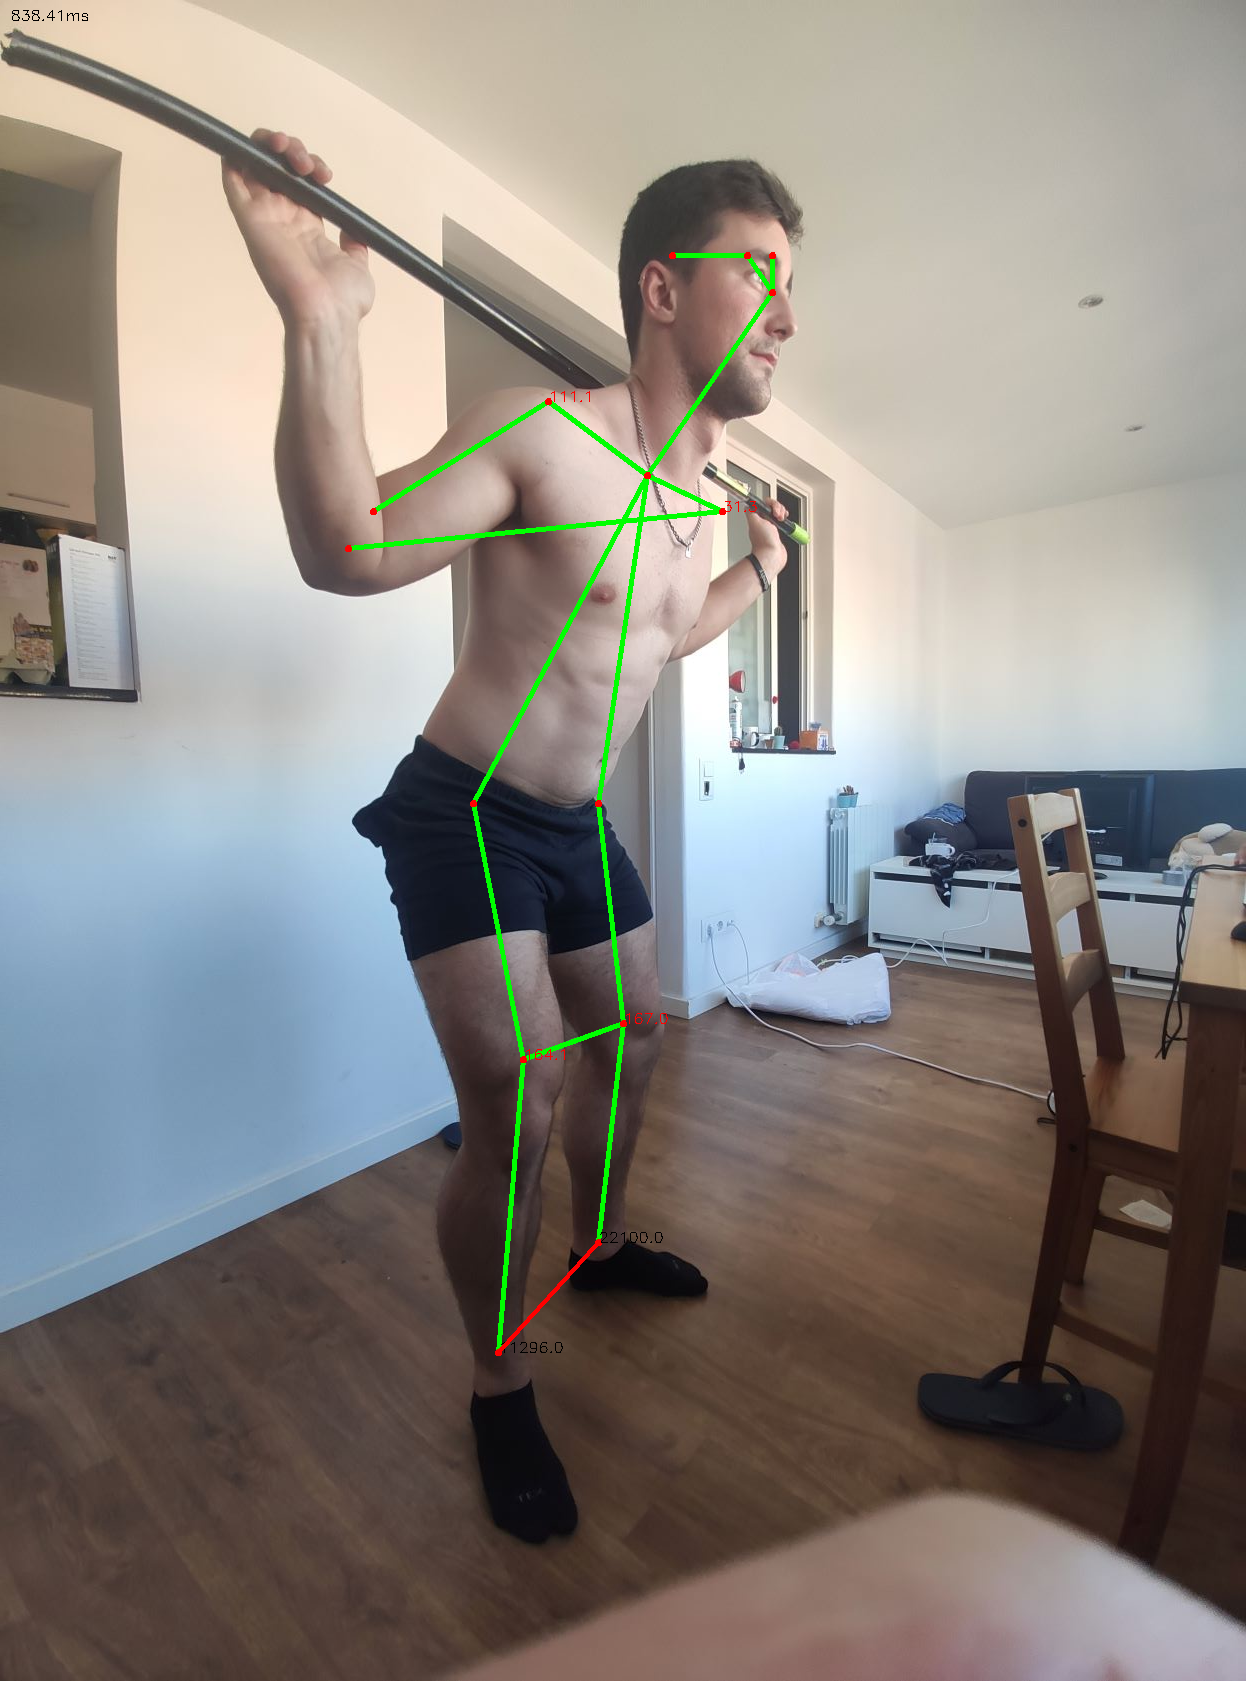

In [ ]:
input = cv.imread("/gdrive/MyDrive/MyFit_IA/human-pose-estimation-opencv/Perspectiva1.jpg")
output = pose_key_angles(input)

cv2_imshow(output)


In [ ]:
import cv2

cap = cv2.VideoCapture("/content/human-pose-estimation-opencv/dance.mp4")
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('niko_baila.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = pose_key_angles(input)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
Done processing video
